In [ ]:
# LSTM Pipeline for Nifty100
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import datetime

In [ ]:
# 1. Data Download
# Example: Nifty100 index symbol on Yahoo Finance is "^CNX100"
symbol = "^CNX100"

# Define date range
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=3*365 + 42)  # ~3 years + 6 weeks

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Close']]  # Using only Close price
df.dropna(inplace=True)

print(f"Data downloaded: {df.shape[0]} rows")
print(df.head())

/tmp/ipython-input-1975676889.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data downloaded: 763 rows
Price              Close
Ticker           ^CNX100
Date                    
2022-07-01  15925.950195
2022-07-04  16018.150391
2022-07-05  16001.599609
2022-07-06  16196.250000
2022-07-07  16339.099609


In [ ]:
# 2. Train-Test Split
# Last 6 weeks (~30 trading days) for test
test_size = 30
train_df = df.iloc[:-test_size]
test_df = df.iloc[-(test_size + 60):]  # include lookback window for test

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

In [ ]:
# 3. Create sequences
SEQ_LEN = 60

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# 4. Build LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LEN, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 6. Train
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(X_train, y_train,
          epochs=100,
          batch_size=16,
          validation_split=0.1,
          callbacks=[es],
          verbose=1)

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - loss: 0.0654 - val_loss: 0.0035
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - loss: 0.0066 - val_loss: 0.0023
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0061 - val_loss: 0.0055
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 180ms/step - loss: 0.0060 - val_loss: 0.0161
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - loss: 0.0097 - val_loss: 0.0066
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 10/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 11/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 12/100
37/37 ━━━━━━━━━━━━━━━━━━

In [ ]:
# 5. Train
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.1371 - val_loss: 0.0350
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0131 - val_loss: 0.0074
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0062 - val_loss: 0.0023
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0035 - val_loss: 0.0019
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0

In [ ]:
# 6. Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


In [ ]:
# 7. Evaluation
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mape = mean_absolute_percentage_error(y_test_inv, y_pred) * 100
direction_accuracy = np.mean(
    np.sign(y_test_inv[1:] - y_test_inv[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])
) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Directional Accuracy: {direction_accuracy:.2f}%")

RMSE: 441.29
MAPE: 1.39%
Directional Accuracy: 55.17%


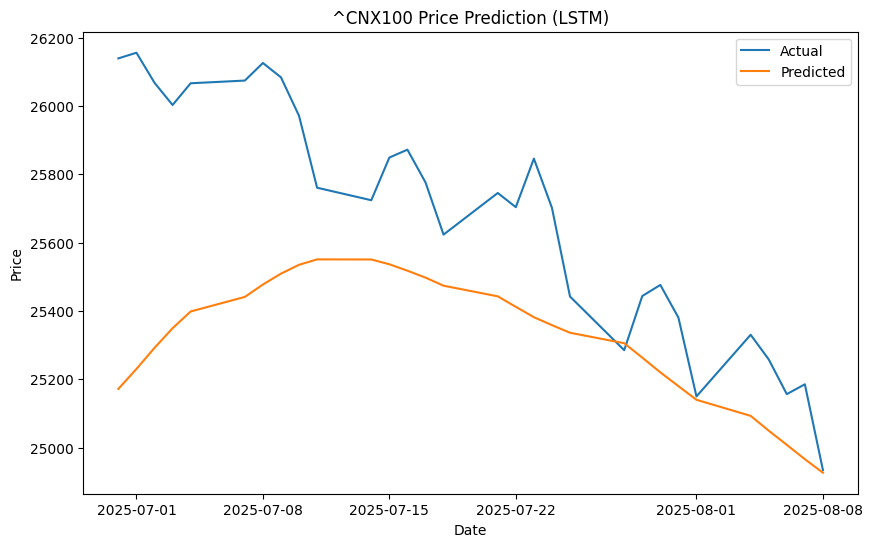

In [ ]:
# 8. Plot results
plt.figure(figsize=(10, 6))
plt.plot(test_df.index[SEQ_LEN:], y_test_inv, label="Actual")
plt.plot(test_df.index[SEQ_LEN:], y_pred, label="Predicted")
plt.title(f"{symbol} Price Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [ ]:
# ARIMA Benchmark Model (Rolling Forecast)
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Same p,d,q as before (can be tuned or auto-selected)
p, d, q = 5, 1, 0

# Ensure these are Series, not DataFrames
train_series = train_df['Close'].astype(float).squeeze()
test_series = test_df['Close'][SEQ_LEN:].astype(float).squeeze()

# Convert to list for rolling updates
history = train_series.to_list()  # <-- now it's a pure Python list of floats
predictions = []

In [ ]:
# Rolling forecast loop
for t in range(len(test_series)):
    model_arima = ARIMA(history, order=(p, d, q))
    model_fit = model_arima.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test_series.iloc[t])  # add the actual next value

In [ ]:
# Create Series for plotting
forecast = pd.Series(predictions, index=test_series.index)

In [ ]:
# Evaluation
rmse_arima = np.sqrt(mean_squared_error(test_series, forecast))
mape_arima = mean_absolute_percentage_error(test_series, forecast) * 100
direction_accuracy_arima = np.mean(
    np.sign(test_series.values[1:] - test_series.values[:-1]) ==
    np.sign(forecast.values[1:] - forecast.values[:-1])
) * 100

print(f"[ARIMA] RMSE: {rmse_arima:.2f}")
print(f"[ARIMA] MAPE: {mape_arima:.2f}%")
print(f"[ARIMA] Directional Accuracy: {direction_accuracy_arima:.2f}%")

[ARIMA] RMSE: 134.46
[ARIMA] MAPE: 0.43%
[ARIMA] Directional Accuracy: 48.28%


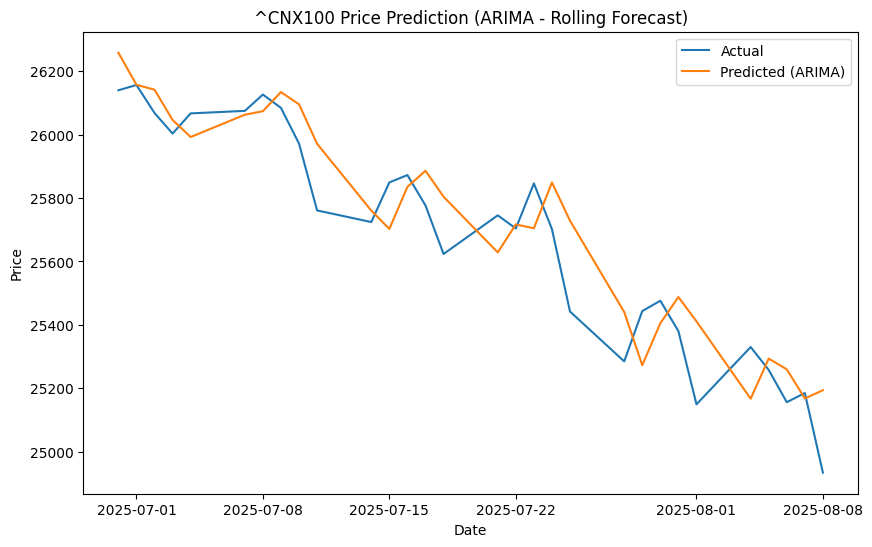

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(test_series.index, test_series, label="Actual")
plt.plot(test_series.index, forecast, label="Predicted (ARIMA)")
plt.title(f"{symbol} Price Prediction (ARIMA - Rolling Forecast)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()